In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Africa Soil Prediction

##pH is the target variable for predictions. 

####The data have been monotonously transformed from the original measurements and thus include negative values. 

   * PIDN: unique soil sample identifier
   * pH: pH values
   * ELEV: Shuttle Radar Topography Mission elevation data
   * Ref: average long-term Reflectance measurements from MODIS satellite images (Ref2 = red)
   * BSA: average long-term Black Sky Albedo measurements from MODIS satellite images (BSAN = near-infrared)
   * LST: average long-term Land Surface Temperatures from MODIS satellite images (LSTN = night time temperature)
   * Infrared01 - Infrared05: These are 5 bands of infrared absorbance measurements.

In [4]:
data = pd.read_csv("/Users/mrgholt/GADS-22-NYC/Datasets/africa_ph.csv")

#Remove the "Unnamed: 0" column and the "PIDN" column for convenience
del data['Unnamed: 0']
del data["PIDN"]

#A brute force approach

In [5]:
#Obtain a list of the all of the columns
predictors = list(data.columns.values)

#Remove 'pH' from the list
predictors.remove('pH')

print predictors

['ELEV', 'REF2', 'BSAN', 'LSTN', 'Infrared01', 'Infrared02', 'Infrared03', 'Infrared04', 'Infrared05']


---
#Essential Functions
---

In [60]:
def brute_force(data, target_variable, predictors, model, alpha_list = [1.0], degree_list = [3]):
    ''' brute_force is a simple function designed to:
    test every combination of predictors submitted in the predictors argument
    test all degrees of polynomial as submitted in the degree_list argument
    test a number of regularization parameters as submitted in the alpha_list argument
    
    model is the algorithm to be tested
     '''
    min_mse = 1e99
    test_size_split = 0.5

    #search over every combination of the predictors - using the itertools functionality
    for i in xrange(1, len(predictors)):
        
        #build and test a model for each combination of predictors
        for j in combinations(predictors, i):
            
            test_predictors = list(j)
            
            #use train test split to get the training and test datasets, according to the parameter test_size_split
            X_train, X_test, y_train, y_test = train_test_split(data[test_predictors], \
                                                    data[target_variable], test_size=test_size_split, random_state=42)
            
            #Now search over all the polynomial degrees in the degree_list
            for degree in degree_list:
                
                #Make sure each model is regularized, and search over all alphas in the regularization list
                for a in alpha_list:
                    
                    #build the model
                    clf = make_pipeline(PolynomialFeatures(degree), model(alpha = a))
                    
                    #fit the model
                    clf.fit(X_train, y_train)
                    
                    #Get the test set predictions
                    y_hat = clf.predict(X_test)
                    
                    #measure the mean squared error of the test set
                    mse = mean_squared_error(y_hat, y_test)
                    
                    #remember ALL information for the minimum
                    if mse < min_mse:
                        min_mse = mse
                        min_clf = clf
                        min_predictors = test_predictors
                        min_degree = degree
                        min_alpha = a
                        #unless you cannot afford to do this, it is always a good idea to remember the train, test
                        #datasets actually used to build your model
                        min_X_train = X_train
                        min_y_train = y_train
                        min_X_test = X_test
                        min_y_test = y_test
                    
    #return a tuple for the minimum model and parameters
    return (min_mse, min_clf, min_predictors, min_degree, min_alpha, min_X_train, min_y_train, min_X_test, min_y_test)

In [80]:
def print_essential_results(results):
    print "MSE = {:5.3f}".format(results[0])
    print "Best predictors = ", results[2]
    print "Optimal degree polynomial = ", results[3]
    print "Optimal regularization value = ", results[4]

In [65]:
def get_degree_v_mse(results, model, degree_list=[3], ylog=1.0, ylim_high=1.0):
    '''get_degree_v_mse uses the results list to produce a plot of degree vs mse for the training
    and test sets'''
    
    #use the regularization parameter you found in the brute force routine
    model_alpha = results[4]

    #set up the lists to accumulate the MSE's
    training_error = []
    testing_error = []
    
    #Search through each degree in the supplied degree_list
    for degree in degree_list:
        
        #Build the model
        clf = make_pipeline(PolynomialFeatures(degree), model(alpha=model_alpha))
        
        #Fit the model using the training data from the brute force routine
        clf.fit(results[5], results[6])
        
        #Accumulate the mse results for the training and test sets
        training_error.append(mean_squared_error(results[6], clf.predict(results[5])))
        testing_error.append(mean_squared_error(results[8], clf.predict(results[7])))
    
    #Plot the results
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.plot(np.array(degree_list), np.array(training_error), color = 'green', marker = 'o', label='Training Error')
    ax.plot(np.array(degree_list), np.array(testing_error), color = 'red', marker = 'o', label='Validation Error')
    ax.set_title("PLot of MSE vs Poylnomial Degree")
    if ylog:
        ax.set_yscale('Log')
        ax.set_ylabel('Log(MSE)')
    else:
        ax.set_ylabel('MSE')

    ax.set_ylim(0.01, ylim_high)
    ax.set_xlabel('Degree')
    ax.legend(loc='upper left')

In [67]:
def get_alpha_v_mse(results, model, alpha_list=[0.1], ylog=1.0, ylim_high=1.0):
    '''get_alpha_v_mse uses the results list to produce a plot of regularization vs mse for the training
    and test sets'''
    
    #use the polynomial degree you found in the brute force routine
    max_degree = results[3]

    #set up the lists to accumulate the MSE's
    training_error = []
    testing_error = []
    
    #Search through each regularization parameter in the supplied alpha_list
    for a in alpha_list:
        
        #build the model
        clf = make_pipeline(PolynomialFeatures(max_degree), model(alpha=a))
        
        #fit the model using the training set used in the brute force routine
        clf.fit(results[5], results[6])
        
        #accumulate the mse for the training and test sets
        training_error.append(mean_squared_error(results[6], clf.predict(results[5])))
        testing_error.append(mean_squared_error(results[8], clf.predict(results[7])))
    
    
    #plot the results
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.plot(np.array(alpha_list), np.array(training_error), color = 'green', marker = 'o', label='Training Error')
    ax.plot(np.array(alpha_list), np.array(testing_error), color = 'red', marker = 'o', label='Validation Error')
    ax.set_title("PLot of Regularization vs Poylnomial Degree")
    if ylog:
        ax.set_yscale('Log')
        ax.set_ylabel('Log(MSE)')
    else:
        ax.set_ylabel('MSE')

    ax.set_ylim(0.01, ylim_high)
    ax.set_xscale('Log')
    ax.set_xlabel('Log Alpha')
    ax.legend(loc='upper right')

In [89]:
def plot_results(results):
    '''plots out the the y_test predictions (y_hat) vs the actual, known results'''
    
    mpl.style.use('ggplot')
    half_points = len(results[8])/2

    fig = plt.figure(figsize=(20, 5))
    ax = plt.subplot(311)
    ax.plot(results[8][:half_points], color = 'blue', marker='o')
    ax.plot(results[1].predict(results[7])[:half_points], color="red", marker='o')
    
    ax = plt.subplot(312)
    ax.plot(results[8][half_points:], color = 'blue', marker='o')
    ax.plot(results[1].predict(results[7])[half_points:], color="red", marker='o')
    
    max_points_to_display = 100
    yy = np.ones(len(results[8]))
    thigh = results[1].predict(results[7]) + (yy * np.sqrt(results[0]))
    tlow = results[1].predict(results[7]) - (yy * np.sqrt(results[0]))
    x_plot = np.arange(0, len(results[8]))

    ax = plt.subplot(313)
    ax.plot(results[8][:max_points_to_display], color = 'blue', marker='.')
    ax.plot(results[1].predict(results[7])[:max_points_to_display], color="red", marker='.', alpha=0.35)
    ax.fill_between(x_plot[:max_points_to_display], thigh[:max_points_to_display],\
                tlow[:max_points_to_display], color='k', alpha=.25)

---
#Utilizing the Functions
---

---
#Investigate Ridge Regression
---

In [61]:
#Let's try and find a brute force minimum using the Ridge algorithm
ridge_results = brute_force(data, \
                        'pH', \
                        predictors, \
                        Ridge, \
                        alpha_list=[0.5, 1.0, 2.0], 
                        degree_list = [1, 2, 3, 5])

In [81]:
print_essential_results(ridge_results)

MSE = 0.268
Best predictors =  ['REF2', 'BSAN', 'LSTN', 'Infrared01', 'Infrared02', 'Infrared03', 'Infrared04', 'Infrared05']
Optimal degree polynomial =  5
Optimal regularization value =  0.5


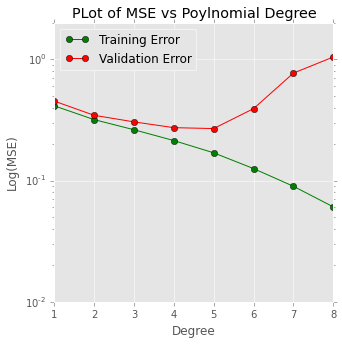

In [66]:
get_degree_v_mse(ridge_results, Ridge, \
                   degree_list = [1, 2, 3, 4, 5, 6, 7, 8], ylog = 1, ylim_high=2.0)

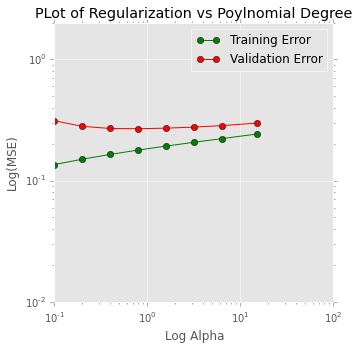

In [68]:
get_alpha_v_mse(ridge_results, Ridge, \
                   alpha_list = [0.0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 15], ylog = 1, ylim_high=2.0)

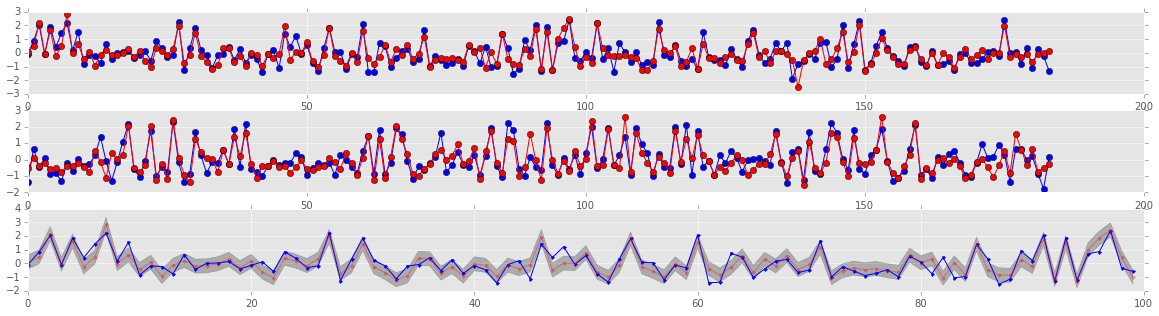

In [94]:
plot_results(ridge_results)

In [95]:
pd.DataFrame({'actual' : ridge_results[8], 'predicted' : ridge_results[1].predict(ridge_results[7])}).corr()

,actual,predicted
actual,1.000000,0.843413
predicted,0.843413,1.000000


---
#Investigate Lasso Regression
---

In [90]:
lasso_results = brute_force(data, \
                        'pH', \
                        predictors, \
                        Lasso, \
                        alpha_list=[0.0000001, 0.000001, 0.00001, 0.00002], 
                        degree_list = [1, 2, 3, 5])

In [91]:
print_essential_results(lasso_results)

MSE = 0.253
Best predictors =  ['REF2', 'BSAN', 'LSTN', 'Infrared02', 'Infrared03', 'Infrared04', 'Infrared05']
Optimal degree polynomial =  3
Optimal regularization value =  1e-05


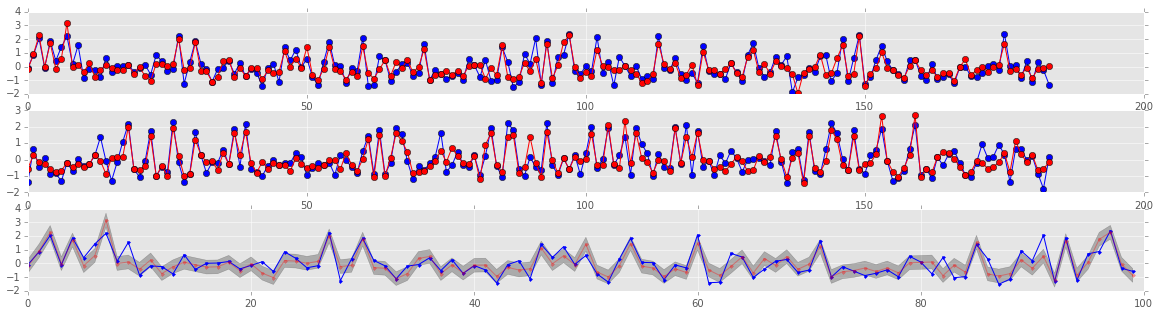

In [96]:
plot_results(lasso_results)

In [93]:
pd.DataFrame({'actual' : lasso_results[8], 'predicted' : lasso_results[1].predict(lasso_results[7])}).corr()

,actual,predicted
actual,1.000000,0.851256
predicted,0.851256,1.000000
